## STEP 1 - Setup


imports:

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import shap



we set the random seeds to be able to reproduce the results and get the gpu

we then load the dataset:

In [2]:
max_features = 10000  # vocabulary size
max_len = 200  # max sequence length

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# convert integers back to words
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# pad sequences
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## STEP 2 - Building and training the model

we create a model that will be trained on the IMDB dataset:

In [3]:
# initialize a sequential model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# we then train the model:

In [4]:
# train the model using a subset of the data
history = model.fit(
  x_train[:5000], y_train[:5000],
  epochs=5,
  batch_size=32,
  validation_split=0.2,
  verbose=1
)


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 388ms/step - accuracy: 0.5622 - loss: 0.6766 - val_accuracy: 0.7650 - val_loss: 0.5116
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 364ms/step - accuracy: 0.8284 - loss: 0.4073 - val_accuracy: 0.8190 - val_loss: 0.4318
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.9136 - loss: 0.2496 - val_accuracy: 0.7680 - val_loss: 0.5094
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 373ms/step - accuracy: 0.9400 - loss: 0.1738 - val_accuracy: 0.7920 - val_loss: 0.6654
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.9685 - loss: 0.0962 - val_accuracy: 0.7620 - val_loss: 0.7050


and finally we evaluate the trained model:

In [5]:
# get accuracy score
score = model.evaluate(x_test[:1000], y_test[:1000], verbose=0)
print(f"test accuracy: {score[1]:.4f}")

test accuracy: 0.7770


## STEP 3 - SHAP
we implement the shap explainer:

In [6]:
explainer = shap.Explainer(model, x_train[:50])
shap_values = explainer(x_test[:20])

PermutationExplainer explainer: 21it [01:06,  3.68s/it]


display the summary plot:

we first need to create a mapping back from feature names to words, for interpertability

In [7]:
inverted_word_index = dict(
    (i + 3, word) for (word, i) in word_index.items()
)

feature_names = [
    inverted_word_index.get(i, f"<{i}>") for i in range(1, max_features + 1)
]

<ipython-input-8-8e8d13d5e334>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names, plot_type='bar')


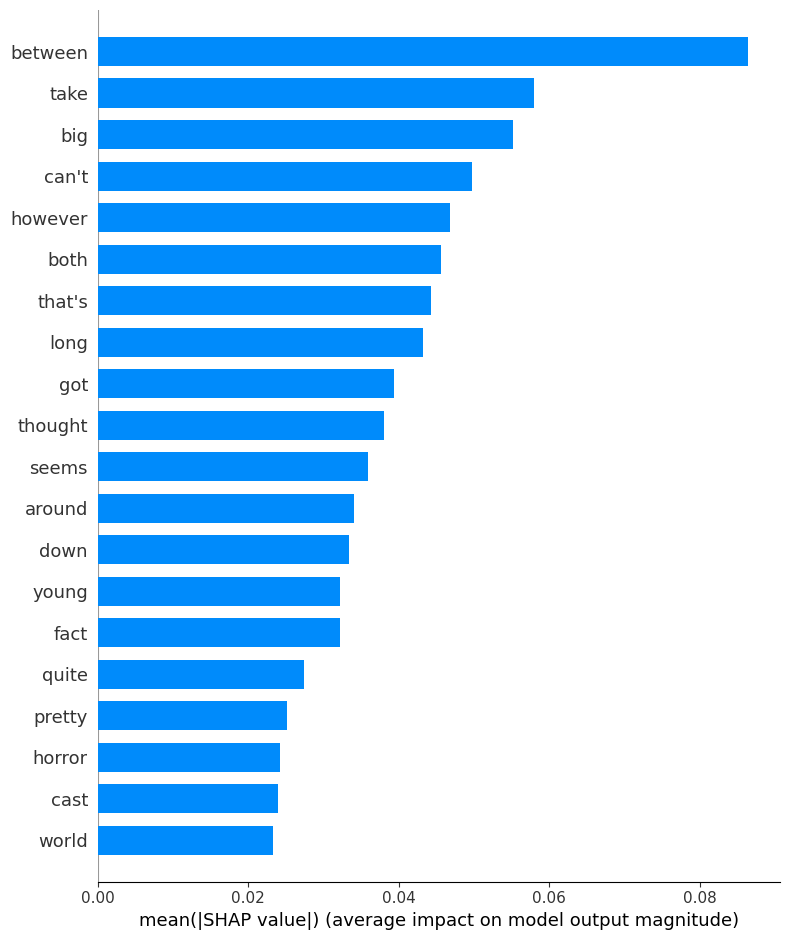

<ipython-input-8-8e8d13d5e334>:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names)


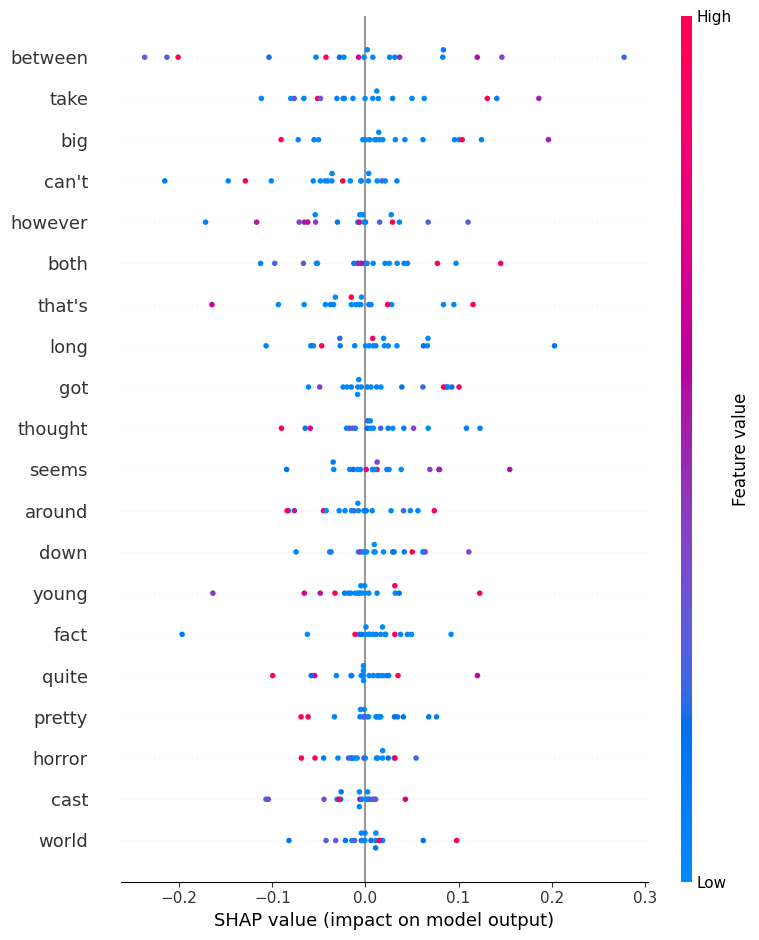

<ipython-input-8-8e8d13d5e334>:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names, plot_type='dependence')


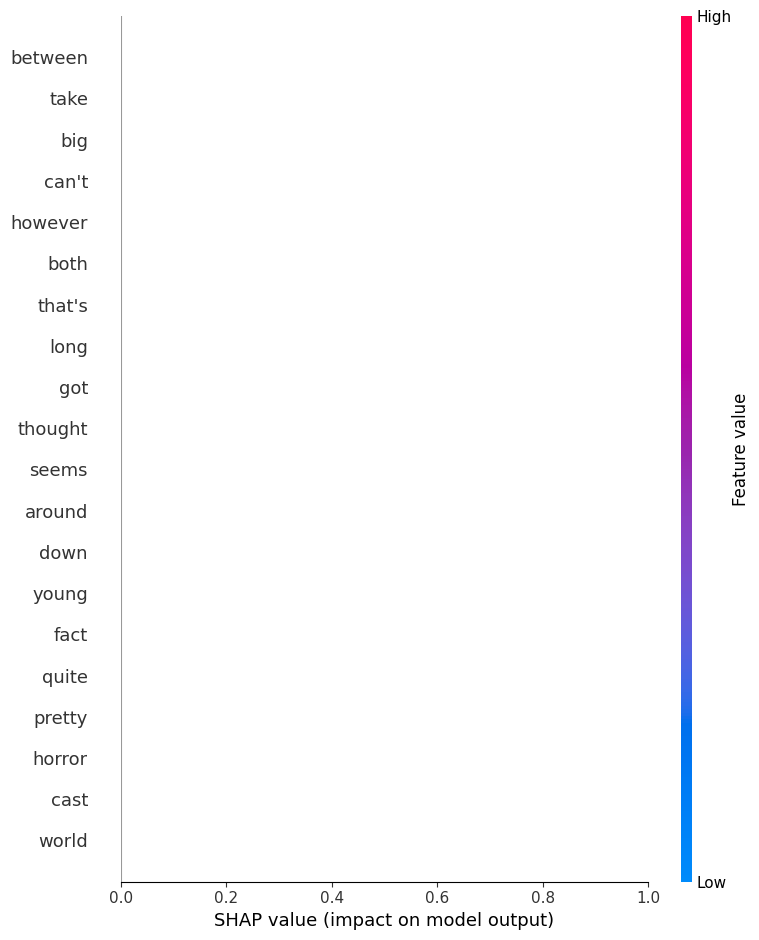

In [8]:
# plot
shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names, plot_type='bar')
shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names)
shap.summary_plot(shap_values, x_test[:20], feature_names=feature_names, plot_type='dependence')



## STEP 5 - Anchors

we then implement the anchors:

First, we need to create a prediction function for the model

In [9]:

def predict_fn(texts):
    if isinstance(texts, str):
        texts = [texts]

    # tokenize and preprocess the text
    sequences = []
    for text in texts:
        # split the text into words
        words = text.lower().split()
        # convert words to indices
        sequence = [word_index.get(word, 0) + 3 for word in words]
        sequences.append(sequence)

    # pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # make predictions
    preds = model.predict(padded_sequences)
    return (preds > 0.5).astype(int).reshape(-1)

# load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    import os
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

# create the AnchorText explainer
anchor_explainer = AnchorText(predict_fn, nlp)

# select a sample from the test set to explain
idx = 0
text = decode_review(x_test[idx])
true_label = y_test[idx]

# generate the anchor explanation
explanation = anchor_explainer.explain(text, threshold=0.95)

# display the explanation
print(f"Prediction: {'Positive' if predict_fn(text)[0] == 1 else 'Negative'}")
print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
print(f"Anchor: {explanation.anchor}")
print(f"Precision: {explanation.precision:.2f}")
print(f"Coverage: {explanation.coverage:.2f}")

# print the rules in human-readable format
print("\nRule: IF")
for i, feature in enumerate(explanation.anchor):
    print(f"  {feature}{' AND' if i < len(explanation.anchor)-1 else ''}")
print(f"THEN the model predicts {'Positive' if predict_fn(text)[0] == 1 else 'Negative'} sentiment with {explanation.precision:.2f} precision")

NameError: name 'spacy' is not defined

## STEP 6 - Visualization

we then visualize the comparison